# Drain3 log与模板匹配的实现

In [18]:
import os
import json
import re
from log_parser import parse_log_line

import matplotlib.pyplot as plt
from skimage import io
import seaborn as sns
import warnings
import numpy as np
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from pylab import mpl, plt
import matplotlib.patches as mpatches

# best font and style settings for notebook 
warnings.filterwarnings('ignore')
sns.set_style("white")
mpl.rcParams['font.family'] = 'MiSans'

# 设置日志主目录
log_root_path = r".\2025_5_8_log_all"
log_extensions = (".log", ".txt", ".out")
all_log_files = []

# 扫描所有日志文件路径
for root, dirs, files in os.walk(log_root_path):
    for file in files:
        if file.lower().endswith(log_extensions):
            full_path = os.path.join(root, file)
            all_log_files.append(full_path)

print(f"共找到 {len(all_log_files)} 个日志文件")
# print(all_log_files)

# 收集所有解析后的日志
parsed_logs = []

for path in all_log_files:
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parsed = parse_log_line(line, source_file=path)
            if parsed:
                parsed_logs.append(parsed)

print(f"成功解析出 {len(parsed_logs)} 条日志记录")

共找到 24 个日志文件
成功解析出 362034 条日志记录


## 单条log案例

In [19]:
parsed_logs[100]

{'source_file': '.\\2025_5_8_log_all\\dm日志及错误编码\\dm_RAC0_202504.log',
 'timestamp': '00:00:54',
 'level': 'INFO',
 'content': '2025-04-30 00:00:54.621 [INFO] database P0000009826 T0000000000000011334  ckpt2_log_adjust: full_status: 160, ptx_reserved: 16'}

In [20]:
len(parsed_logs)

362034

In [21]:
import re
from drain3 import TemplateMiner
from drain3.file_persistence import FilePersistence
from drain3.template_miner_config import TemplateMinerConfig
import logging
from collections import defaultdict
import pandas as pd

# ✅ Step 1: 日志设置
logging.basicConfig(level=logging.INFO, format="%(message)s")

# ✅ Step 2: 自定义参数配置
from drain3.template_miner_config import TemplateMinerConfig

config = TemplateMinerConfig()
config.load("drain3.ini")  # 如果没有文件会自动加载内置默认配置
config.drain_sim_th = 0.7  # 提高相似度容忍
config.drain_max_depth = 5  # 增加树深
config.drain_max_children = 100  # 增加匹配宽度

# ✅ Step 3: 初始化 Drain 模板挖掘器
persistence = FilePersistence("drain3_state.json")
template_miner = TemplateMiner(persistence, config)


# ✅ Step 4: 日志预处理函数
def preprocess_log(log: str) -> str:
    log = re.sub(r"\d{4}-\d{2}-\d{2}( \d{2}:\d{2}:\d{2}(\.\d+)?)?", "<DATE>", log)
    log = re.sub(r"P\d{10}", "<P_ID>", log)
    log = re.sub(r"T\d{16}", "<T_ID>", log)
    log = re.sub(r"full_status:\s*\d+", "full_status: <STATUS>", log)
    log = re.sub(r"ptx_reserved:\s*\d+", "ptx_reserved: <RESERVED>", log)
    return log


# ✅ Step 5: 批量处理前1000条日志
results = []
template_stats = defaultdict(list)

for idx, log_item in enumerate(parsed_logs[:5000]):
    log_content_raw = log_item.get('content', '').strip()
    if not log_content_raw:
        continue

    log_content = preprocess_log(log_content_raw)

    result = template_miner.add_log_message(log_content)

    if result is not None:
        template = result.get('template_mined')
        variables = result.get('parameter_list', [])

        if template:
            results.append({
                'log_id': idx,
                'template': template,
                'variables': variables,
                'original': log_content_raw
            })
            template_stats[template].append(idx)

# ✅ Step 6: 打印示例结果
print("\n🔍 示例模板匹配结果 (前5条):")
for r in results[:5]:
    print(f"\n[Log ID] {r['log_id']}")
    print("Original :", r['original'])
    print("Template :", r['template'])
    print("Variables:", r['variables'])

config file not found: drain3.ini
Starting Drain3 template miner
Checking for saved state
Restored 2184 clusters built from 365782 messages



🔍 示例模板匹配结果 (前5条):

[Log ID] 0
Original : 2025-04-30 00:00:01.319 [WARNING] database P0000009826 T0000000000000034013  socket_err_should_retry errno:38
Template : <DATE> [WARNING] database <P_ID> <*> socket_err_should_retry <*>
Variables: []

[Log ID] 1
Original : 2025-04-30 00:00:03.926 [INFO] database P0000009826 T0000000000000011404  checkpoint requested by CKPT_DIRTY_PAGES, rlog free space[21399052288], used space[75776000]
Template : <DATE> [INFO] database <P_ID> <*> checkpoint requested by <*> rlog free <*> used <*>
Variables: []

[Log ID] 2
Original : 2025-04-30 00:00:03.926 [INFO] database P0000009826 T0000000000000011404  checkpoint generate by dirty_pages[10946] > ckpt_dirty_pages[10000]
Template : <DATE> [INFO] database <P_ID> <*> checkpoint generate by <*> > <*>
Variables: []

[Log ID] 3
Original : 2025-04-30 00:00:03.926 [INFO] database P0000009826 T0000000000000011334  checkpoint begin, used_space[75776000], free_space[21399052288]...
Template : <DATE> [INFO] database <P_

In [22]:
len(results)

5000

In [23]:
# ✅ Step 7: 模板统计
print("\n📊 模板汇总统计:")
template_df = []
for template, ids in sorted(template_stats.items(), key=lambda x: -len(x[1]))[:3]:
    print(f"\nTemplate : {template}")
    print(f"Count    : {len(ids)}")
    print(f"Log IDs  : {ids[:5]}{'...' if len(ids) > 5 else ''}")

for template, ids in sorted(template_stats.items(), key=lambda x: -len(x[1]))[:]:
    template_df.append([template, len(ids), ids])


📊 模板汇总统计:

Template : <DATE> [INFO] database <P_ID> <T_ID>334 ckpt2_request_far_ep_flush dest_seq:1 <*>
Count    : 1023
Log IDs  : [7, 8, 14, 15, 21]...

Template : <DATE> [INFO] database <P_ID> <*> checkpoint requested by <*> rlog free <*> used <*>
Count    : 545
Log IDs  : [1, 12, 19, 26, 34]...

Template : <DATE> [INFO] database <P_ID> <T_ID>334 checkpoint begin, <*> <*>
Count    : 545
Log IDs  : [3, 13, 20, 28, 36]...


In [24]:
template_df = pd.DataFrame(template_df, columns=['模板', '与模板匹配的log数量', '与模板log id的列表'])
template_df['累计'] = template_df['与模板匹配的log数量'].cumsum()
template_df['累计百分比'] = template_df['累计'] / len(results)
template_df

,模板,与模板匹配的log数量,与模板log id的列表,累计,累计百分比
0,<DATE> [INFO] database <P_ID> <T_ID>334 ckpt2_...,1023,"[7, 8, 14, 15, 21, 22, 29, 30, 37, 38, 45, 46,...",1023,0.2046
1,<DATE> [INFO] database <P_ID> <*> checkpoint r...,545,"[1, 12, 19, 26, 34, 42, 50, 59, 70, 79, 95, 10...",1568,0.3136
2,<DATE> [INFO] database <P_ID> <T_ID>334 checkp...,545,"[3, 13, 20, 28, 36, 43, 52, 61, 72, 81, 97, 10...",2113,0.4226
3,<DATE> [INFO] database <P_ID> <T_ID>334 checkp...,544,"[11, 18, 25, 33, 41, 49, 58, 66, 78, 88, 102, ...",2657,0.5314
4,<DATE> [INFO] database <P_ID> <*> ckpt2_log_ad...,506,"[9, 16, 23, 31, 39, 47, 56, 64, 76, 86, 100, 1...",3163,0.6326
...,...,...,...,...,...
524,<DATE> [INFO] database <P_ID> <T_ID>334 ckpt2_...,1,[4962],4996,0.9992
525,<DATE> [INFO] database <P_ID> <T_ID>334 ckpt2_...,1,[4969],4997,0.9994
526,<DATE> [INFO] database <P_ID> <T_ID>334 ckpt2_...,1,[4976],4998,0.9996
527,<DATE> [INFO] database <P_ID> <T_ID>334 ckpt2_...,1,[4985],4999,0.9998


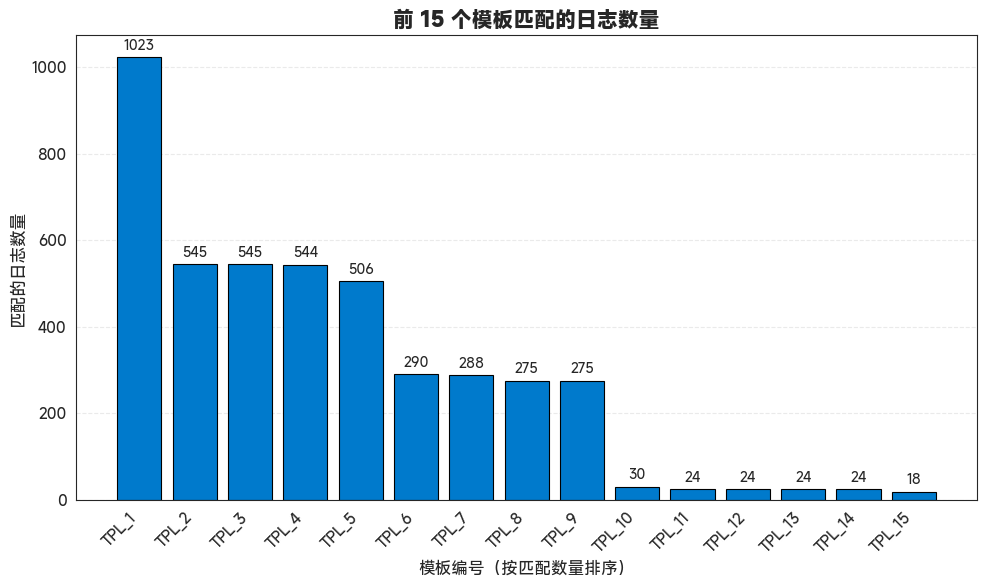

In [25]:
import matplotlib.pyplot as plt

# 设置样式统一颜色与字体
plt.rcParams.update({'font.size': 11, 'axes.titlesize': 15, 'axes.labelsize': 12})

# ✅ 设置只显示前 N 个模板
N = 15
top_templates = template_df.sort_values(by='与模板匹配的log数量', ascending=False).head(N)

plt.figure(figsize=(10, 6))
bars = plt.bar(
    range(N),
    top_templates['与模板匹配的log数量'],
    color='#007acc',
    edgecolor='black',
    linewidth=0.8
)

# ✅ 模板索引（编号）作为 x 轴
x_labels = [f'TPL_{i + 1}' for i in range(N)]
plt.xticks(range(N), x_labels, rotation=45, ha='right')

plt.ylabel("匹配的日志数量")
plt.xlabel("模板编号（按匹配数量排序）")
plt.title(f"前 {N} 个模板匹配的日志数量", fontweight='bold')

# ✅ 添加柱顶数字
for i, count in enumerate(top_templates['与模板匹配的log数量']):
    plt.text(i, count + max(top_templates['与模板匹配的log数量']) * 0.01,
             str(count), ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


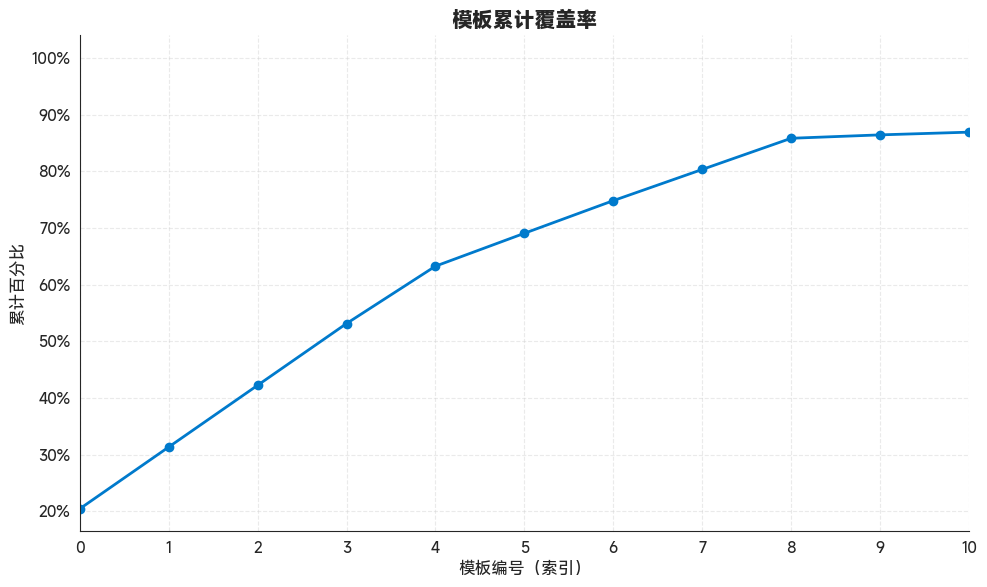

In [26]:
plt.figure(figsize=(10, 6))
template_df['累计百分比'].plot(kind='line', marker='o', color='#007acc', linewidth=2, markersize=6)

plt.title("模板累计覆盖率", fontweight='bold')
plt.xlabel("模板编号（索引）")
plt.ylabel("累计百分比")

# ✅ 设置连续 x 轴刻度 & 限制范围
plt.xticks(range(11))
plt.xlim(0, 10)

# ✅ 百分比显示格式
from matplotlib.ticker import FuncFormatter

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))

# ✅ 去掉边框，统一风格
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [27]:
# ✅ Step 8: 导出 CSV（可选）
df = pd.DataFrame(results)

In [28]:
df

,log_id,template,variables,original
0,0,<DATE> [WARNING] database <P_ID> <*> socket_er...,[],2025-04-30 00:00:01.319 [WARNING] database P00...
1,1,<DATE> [INFO] database <P_ID> <*> checkpoint r...,[],2025-04-30 00:00:03.926 [INFO] database P00000...
2,2,<DATE> [INFO] database <P_ID> <*> checkpoint g...,[],2025-04-30 00:00:03.926 [INFO] database P00000...
3,3,<DATE> [INFO] database <P_ID> <T_ID>334 checkp...,[],2025-04-30 00:00:03.926 [INFO] database P00000...
4,4,<DATE> [WARNING] database <P_ID> <*> socket_er...,[],2025-04-30 00:00:07.718 [WARNING] database P00...
...,...,...,...,...
4995,4995,<DATE> [INFO] database <P_ID> <T_ID>334 ckpt2_...,[],2025-04-30 00:26:29.630 [INFO] database P00000...
4996,4996,<DATE> [INFO] database <P_ID> <T_ID>334 checkp...,[],2025-04-30 00:26:29.631 [INFO] database P00000...
4997,4997,<DATE> [INFO] database <P_ID> <*> checkpoint r...,[],2025-04-30 00:26:29.631 [INFO] database P00000...
4998,4998,<DATE> [INFO] database <P_ID> <T_ID>334 checkp...,[],2025-04-30 00:26:29.631 [INFO] database P00000...


### 正则类型匹配，提取变量

In [29]:
import re

template = "<DATE> [WARNING] database <P_ID> <*> socket_err_should_retry <*>"
original = "2025-04-30   00:00:01.319 [WARNING] database P0000009826 T0000000000000034013  socket_err_should_retry errno:38"


def extract_variables_from_template(template, original):
    # Step 1: Replace <xxx> and <*> with a temporary placeholder for variables
    # We use a unique placeholder that won't conflict with literal characters
    temp_placeholder = "__VAR_PLACEHOLDER__"
    normalized = re.sub(r'<[^>]+>', temp_placeholder, template)

    # Step 2: Escape the entire normalized string for regex
    # This turns literal characters into their escaped form (e.g., [ into \[)
    pattern = re.escape(normalized)

    # Step 3: Convert our temporary placeholder back to the regex capturing group
    # Ensure this happens *after* re.escape, so we target the escaped placeholder
    pattern = pattern.replace(re.escape(temp_placeholder), r'(.+?)')

    # Step 4: Replace single escaped spaces with \s+ for multiple spaces
    pattern = pattern.replace(r'\ ', r'\s+')

    # # Debugging: Print the final pattern to inspect it
    # print(f"Generated Regex Pattern: {pattern}")

    match = re.match(pattern, original)
    return list(match.groups()) if match else []


# Test
variables = extract_variables_from_template(template, original)
print("✅ Extracted variables:", variables)
# 应用到整个 DataFrame 中
df['variables'] = df.apply(lambda row: extract_variables_from_template(row['template'], row['original']), axis=1)
df

✅ Extracted variables: ['2025-04-30   00:00:01.319', 'P0000009826', 'T0000000000000034013', 'e']


,log_id,template,variables,original
0,0,<DATE> [WARNING] database <P_ID> <*> socket_er...,"[2025-04-30 00:00:01.319, P0000009826, T000000...",2025-04-30 00:00:01.319 [WARNING] database P00...
1,1,<DATE> [INFO] database <P_ID> <*> checkpoint r...,"[2025-04-30 00:00:03.926, P0000009826, T000000...",2025-04-30 00:00:03.926 [INFO] database P00000...
2,2,<DATE> [INFO] database <P_ID> <*> checkpoint g...,"[2025-04-30 00:00:03.926, P0000009826, T000000...",2025-04-30 00:00:03.926 [INFO] database P00000...
3,3,<DATE> [INFO] database <P_ID> <T_ID>334 checkp...,"[2025-04-30 00:00:03.926, P0000009826, T000000...",2025-04-30 00:00:03.926 [INFO] database P00000...
4,4,<DATE> [WARNING] database <P_ID> <*> socket_er...,"[2025-04-30 00:00:07.718, P0000009826, T000000...",2025-04-30 00:00:07.718 [WARNING] database P00...
...,...,...,...,...
4995,4995,<DATE> [INFO] database <P_ID> <T_ID>334 ckpt2_...,"[2025-04-30 00:26:29.630, P0000009826, T000000...",2025-04-30 00:26:29.630 [INFO] database P00000...
4996,4996,<DATE> [INFO] database <P_ID> <T_ID>334 checkp...,"[2025-04-30 00:26:29.631, P0000009826, T000000...",2025-04-30 00:26:29.631 [INFO] database P00000...
4997,4997,<DATE> [INFO] database <P_ID> <*> checkpoint r...,"[2025-04-30 00:26:29.631, P0000009826, T000000...",2025-04-30 00:26:29.631 [INFO] database P00000...
4998,4998,<DATE> [INFO] database <P_ID> <T_ID>334 checkp...,"[2025-04-30 00:26:29.631, P0000009826, T000000...",2025-04-30 00:26:29.631 [INFO] database P00000...


![image-20250525135525813](asset_markdown/img.png)

In [30]:
row = df.iloc[2000]

print("🧩 模板 Template:")
print(row["template"])
print("\n📦 提取出的变量 Variables:")
print(row["variables"] if row["variables"] else "（无）")
print("\n📝 原始日志 Original Log:")
print(row["original"])


🧩 模板 Template:
<DATE> [INFO] database <P_ID> <T_ID>334 ckpt2_request_far_ep_flush dest_seq:1 <*>

📦 提取出的变量 Variables:
['2025-04-30 00:09:33.386', 'P0000009826', 'T0000000000000011', 'b']

📝 原始日志 Original Log:
2025-04-30 00:09:33.386 [INFO] database P0000009826 T0000000000000011334  ckpt2_request_far_ep_flush dest_seq:1 begin


In [31]:
df.to_csv(f"drain3_parsed_logs_{len(results)}.csv", index=False)
print(f"\n✅ 解析结果已保存至:drain3_parsed_logs_{len(results)}.csv")


✅ 解析结果已保存至:drain3_parsed_logs_5000.csv


In [ ]:
!jupyter nbconvert --to html log_parsing_drain.ipynb
!jupyter nbconvert --to markdown log_parsing_drain.ipynb